In [1]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import seaborn as sns
import numpy as np
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from sklearn import metrics
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from tensorflow.keras import optimizers

2023-07-19 15:52:30.578973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 15:52:32.046162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [4]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    print('File Path : ',filepath)
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
# load all train
X_train, Y_train = load_dataset_group('train', 'dataset_uci/')
# load all test
X_test, Y_test = load_dataset_group('test', 'dataset_uci/')

# zero-offset class values
Y_train = Y_train - 1
Y_test = Y_test - 1
# one hot encode y
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print('X_train.shape : ', X_train.shape)
print('Y_train.shape : ', Y_train.shape)
print('X_test.shape : ', X_test.shape)
print('Y_test.shape : ', Y_test.shape)

File Path :  dataset_uci/train/Inertial Signals/
File Path :  dataset_uci/test/Inertial Signals/
X_train.shape :  (7352, 128, 9)
Y_train.shape :  (7352, 6)
X_test.shape :  (2947, 128, 9)
Y_test.shape :  (2947, 6)


In [6]:
verbose = 1
epochs = 50
batch_size = 20

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_train.shape[1]

In [7]:
checkpoint = ModelCheckpoint("har_weights.h5", monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq=2)

In [8]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# fit network
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                    epochs=epochs, batch_size=batch_size, callbacks = [checkpoint], verbose=verbose)


# evaluate model
(loss, accuracy) = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

2023-07-19 15:52:38.163152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 15:52:38.451165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 15:52:38.451901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/50


2023-07-19 15:52:43.401464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-19 15:52:45.344553: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-19 15:52:45.543925: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ff08001af70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-19 15:52:45.543998: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-07-19 15:52:45.602338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-19 15:52:46.097845: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-19 15:52:46.192963: I ./tensorflow/compiler/jit/device_comp

368/368 [==============================] - 10s 6ms/step - loss: 0.3475 - accuracy: 0.8624 - val_loss: 0.3365 - val_accuracy: 0.8768
Epoch 2/50
368/368 [==============================] - 2s 5ms/step - loss: 0.1359 - accuracy: 0.9441 - val_loss: 0.3024 - val_accuracy: 0.8992
Epoch 3/50
368/368 [==============================] - 2s 5ms/step - loss: 0.1125 - accuracy: 0.9547 - val_loss: 0.3846 - val_accuracy: 0.8924
Epoch 4/50
368/368 [==============================] - 2s 5ms/step - loss: 0.1221 - accuracy: 0.9539 - val_loss: 0.2955 - val_accuracy: 0.8992
Epoch 5/50
368/368 [==============================] - 2s 5ms/step - loss: 0.1105 - accuracy: 0.9535 - val_loss: 0.3299 - val_accuracy: 0.8924
Epoch 6/50
368/368 [==============================] - 2s 5ms/step - loss: 0.0971 - accuracy: 0.9533 - val_loss: 0.3602 - val_accuracy: 0.8945
Epoch 7/50
368/368 [==============================] - 2s 5ms/step - loss: 0.0931 - accuracy: 0.9542 - val_loss: 0.3777 - val_accuracy: 0.9023
Epoch 8/50
368/3

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 conv1d_1 (Conv1D)           (None, 126, 64)           12352     
                                                                 
 dropout (Dropout)           (None, 126, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4032)              0         
                                                                 
 dense (Dense)               (None, 100)               403300    
                                                        

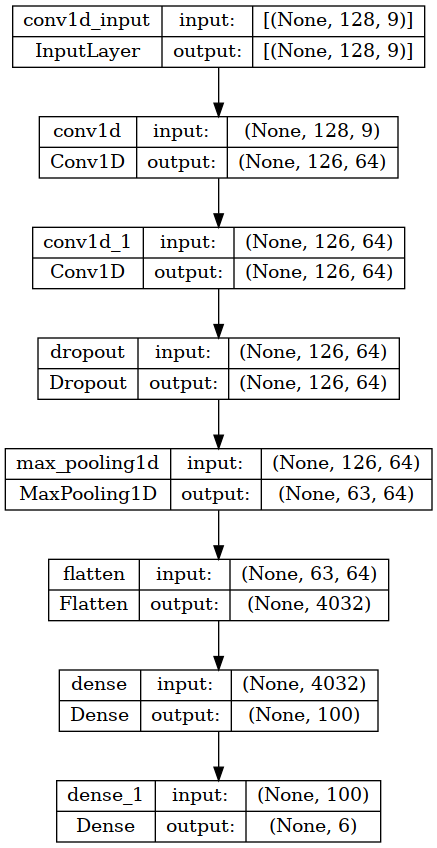

In [10]:
from keras import utils

utils.plot_model(model, to_file=f"results/model.png", show_shapes=True)

In [13]:
from sklearn.metrics import accuracy_score

y_predict_train = model.predict(X_train).argmax(axis=1)
print("Train_accuracy is: ", accuracy_score(Y_train.argmax(axis=1), y_predict_train))

y_predict_test = model.predict(X_test).argmax(axis=1)
print("Test accuracy is: ", accuracy_score(Y_test.argmax(axis=1), y_predict_test))

230/230 [==============================] - 0s 2ms/step
Train_accuracy is:  0.9971436343852013
93/93 [==============================] - 0s 2ms/step
Test accuracy is:  0.9273837801153716


In [14]:
from sklearn import metrics

y_predict_test = model.predict(X_test).argmax(axis=1)
y_predict_train = model.predict(X_train).argmax(axis=1)


print("Test loss is: ", np.sqrt(metrics.mean_squared_error(Y_test.argmax(axis=1), y_predict_test)))
print("Train loss is: ", np.sqrt(metrics.mean_squared_error(Y_train.argmax(axis=1), y_predict_train)))

230/230 [==============================] - 0s 2ms/step
Test loss is:  0.3320867994186921
Train loss is:  0.053444977451568766
